In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from nltk.translate.bleu_score import corpus_bleu
import time
import re

nltk.download('punkt') 
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /home/nikhil/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df=pd.read_csv("translations_3000.csv")
df.head(10)

,English,Hindi,Original
0,A black box in your car?,आपकी कार में एक ब्लैक बॉक्स?,आपकी कार में ब्लैक बॉक्स?
1,As America's road planners struggle to find th...,जैसे ही अमेरिका के सड़क योजनार एक ढही सड़क व्य...,"जबकि अमेरिका के सड़क योजनाकार, ध्वस्त होते हुए..."
2,"The devices, which track every mile a motorist...","ये उपकरण, जो हर मील एक मोटर ड्राइव और ट्रांसमी...","यह डिवाइस, जो मोटर-चालक द्वारा वाहन चलाए गए प्..."
3,The usually dull arena of highway planning has...,आमतौर पर सड़क योजना का कठोर अखाड़ा अचानक भारी ...,आम तौर पर हाईवे नियोजन जैसा उबाऊ काम भी अचानक ...
4,Libertarians have joined environmental groups ...,लिबर्टी ने पर्यावरण समूहों से जुड़ने के लिए सर...,"आपने द्वारा ड्राइव किए गए मील, तथा संभवतः ड्रा..."
5,The tea party is aghast.,चाय पार्टी कम हो गई है।,चाय पार्टी भौचक्की है।
6,The American Civil Liberties Union is deeply c...,अमेरिकी नागरिक संरक्षण संघ भी कई प्रकार की निज...,अमेरिकी नागरिक स्वतंत्रता संघ भी विभिन्न प्रका...
7,And while Congress can't agree on whether to p...,और जबकि कांग्रेस आगे बढ़ने पर सहमत नहीं हो सकत...,जबकि कांग्रेस इस बात पर सहमत नहीं हो सकी कि आग...
8,"They are exploring how, over the next decade, ...","वे खोज कर रहे हैं कि अगले दशक में, वे एक ऐसी प...",वे यह खोज कर रहे हैं कि अगले दशक में वे किस तर...
9,Thousands of motorists have already taken the ...,हजारों मोटरवासियों ने पहले से ही काले बक्से ले...,हजारों मोटर-चालकों ने टेस्ट ड्राइव के लिए पहले...


In [3]:
eng=df['English'].astype(str)
orig=df['Original'].astype(str)
pred=df['Hindi'].astype(str)

In [4]:
eng.head(10)

0                             A black box in your car?
1    As America's road planners struggle to find th...
2    The devices, which track every mile a motorist...
3    The usually dull arena of highway planning has...
4    Libertarians have joined environmental groups ...
5                             The tea party is aghast.
6    The American Civil Liberties Union is deeply c...
7    And while Congress can't agree on whether to p...
8    They are exploring how, over the next decade, ...
9    Thousands of motorists have already taken the ...
Name: English, dtype: object

In [5]:
orig.head(10)

0                            आपकी कार में ब्लैक बॉक्स?
1    जबकि अमेरिका के सड़क योजनाकार, ध्वस्त होते हुए...
2    यह डिवाइस, जो मोटर-चालक द्वारा वाहन चलाए गए प्...
3    आम तौर पर हाईवे नियोजन जैसा उबाऊ काम भी अचानक ...
4    आपने द्वारा ड्राइव किए गए मील, तथा संभवतः ड्रा...
5                               चाय पार्टी भौचक्की है।
6    अमेरिकी नागरिक स्वतंत्रता संघ भी विभिन्न प्रका...
7    जबकि कांग्रेस इस बात पर सहमत नहीं हो सकी कि आग...
8    वे यह खोज कर रहे हैं कि अगले दशक में वे किस तर...
9    हजारों मोटर-चालकों ने टेस्ट ड्राइव के लिए पहले...
Name: Original, dtype: object

In [6]:
pred.head(10)

0                         आपकी कार में एक ब्लैक बॉक्स?
1    जैसे ही अमेरिका के सड़क योजनार एक ढही सड़क व्य...
2    ये उपकरण, जो हर मील एक मोटर ड्राइव और ट्रांसमी...
3    आमतौर पर सड़क योजना का कठोर अखाड़ा अचानक भारी ...
4    लिबर्टी ने पर्यावरण समूहों से जुड़ने के लिए सर...
5                              चाय पार्टी कम हो गई है।
6    अमेरिकी नागरिक संरक्षण संघ भी कई प्रकार की निज...
7    और जबकि कांग्रेस आगे बढ़ने पर सहमत नहीं हो सकत...
8    वे खोज कर रहे हैं कि अगले दशक में, वे एक ऐसी प...
9    हजारों मोटरवासियों ने पहले से ही काले बक्से ले...
Name: Hindi, dtype: object

In [7]:
Jaccard_sim=[]
sim_count=[0]*10
ambiguous_eng=[]
ambiguous_orig=[]
ambiguous_pred=[]
best=[]

Jaccard Similarity

In [8]:
for i in range(len(df)):
    words_orig=set(orig[i].lower().split())
    words_pred=set(pred[i].lower().split())
    intersection=words_orig.intersection(words_pred)
    union=words_orig.union(words_pred)
    sim=float(len(intersection)/len(union))
    Jaccard_sim.append(sim)
    index=int(sim*10)
    if index==10 or index==9:
        best.append(eng[i])
        index=9
    if index==0:
        ambiguous_eng.append(eng[i])
        ambiguous_orig.append(orig[i])
        ambiguous_pred.append(pred[i])
    sim_count[index]+=1
print(sim_count)

[204, 667, 1042, 669, 270, 122, 35, 10, 7, 1]


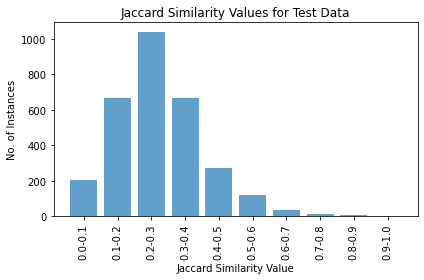

In [9]:
x_labels = [f"{i/10:.1f}-{(i+1)/10:.1f}" for i in range(10)]
x_positions = range(len(sim_count))
plt.bar(x_positions, sim_count, align='center', alpha=0.7)
plt.xticks(x_positions, x_labels, rotation='vertical')

plt.xlabel('Jaccard Similarity Value')
plt.ylabel('No. of Instances')
plt.title('Jaccard Similarity Values for Test Data')
plt.tight_layout()
plt.show()

In [10]:
print(ambiguous_eng)
print(ambiguous_orig)
print(ambiguous_pred)

['Politicians are loath to raise the tax even one penny when gas prices are high.', 'The concept is not a universal hit.', 'Crispy Pea Rolls, Surti Plaza, Barsa Dola, Hariwali Patra, Jodhpuri Pakaros, Dakor na Gota nu Chat and Lilava Kachori will be awaiting you in the Special Diwali Thali.', 'Traditional recipes with vegetables such as Surti Udhiyu, Jaisalmer Panch Kuta, Pithaud ki sabji, Jodhpuri Gatta, Sagaru ke kofte, Rabodi Hara Pyaj, Til wale Aloo, Makai Mirch and Jajaria are included.', 'The best way to end a regal meal is with desserts like Apple Jalebi, Tomato Halwa, Walnut Halwa, Dudh Pak, Date Barfi, Dryfruit Halwa, Makai Jajaria and Sutar Saini Kheer.', "Presenting CAT's trendy footwear and clothing collection.", 'This created a cold front in the valley.', 'As Diwali is approaching the demand for desserts has increased.', 'The department received a tip off that substandard milk solids were being brought from Madhya Pradesh to Nagpur and stored in soil.', "Because of this, a

Cosine Similarity

In [11]:
Cosine_sim=[]
sim_count=[0]*10

In [12]:
for i in range(len(df)):
    token_pred=nltk.word_tokenize(pred[i])
    token_orig=nltk.word_tokenize(orig[i])
    pre1=' '.join(token_pred)
    pre2=' '.join(token_orig)
    vectorizer=CountVectorizer(tokenizer=lambda text: text.split(),token_pattern='')
    vectorizer_text=vectorizer.fit_transform([pre1,pre2])
    sim=cosine_similarity(vectorizer_text)[0][1]
    Cosine_sim.append(sim)
    index=int(sim*10)
    if index==10 or index==9:
        index=9
    sim_count[index]+=1
print(sim_count)

[37, 130, 307, 512, 665, 721, 445, 175, 30, 5]


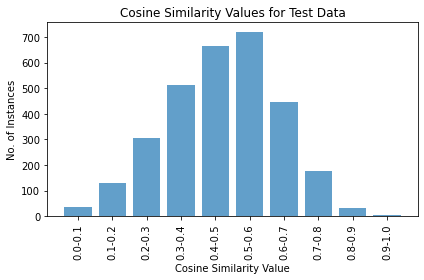

In [13]:
x_labels = [f"{i/10:.1f}-{(i+1)/10:.1f}" for i in range(10)]
x_positions = range(len(sim_count))
plt.bar(x_positions, sim_count, align='center', alpha=0.7)
plt.xticks(x_positions, x_labels, rotation='vertical')

plt.xlabel('Cosine Similarity Value')
plt.ylabel('No. of Instances')
plt.title('Cosine Similarity Values for Test Data')
plt.tight_layout()
plt.show()

BLUE Score

In [14]:
references = []
hypotheses = []

for sentence in df["Hindi"]:
    hypotheses.append(str(sentence))

for sentence in df["Original"]:
    references.append([str(sentence)])

# Calculate BLEU score
bleu_score = corpus_bleu(references, hypotheses)

print(f'BLEU Score: {bleu_score * 100:.2f}%')

BLEU Score: 48.76%
